In [447]:
from skimage import img_as_float
import matplotlib.pyplot as plt
import numpy as np

def imshow_all(*images, titles=None):
    images = [img_as_float(img) for img in images]

    if titles is None:
        titles = [''] * len(images)
    vmin = min(map(np.min, images))
    vmax = max(map(np.max, images))
    ncols = len(images)
    height = 10
    width = height * len(images)
    fig, axes = plt.subplots(nrows=1, ncols=ncols,
                             figsize=(width, height))
    for ax, img, label in zip(axes.ravel(), images, titles):
        ax.imshow(img, vmin=vmin, vmax=vmax,cmap="gray")
        ax.set_title(label)

In [448]:
import cv2
def scale_polygon(polygon, scale_factor):
    # Calculate the centroid of the polygon
    M = cv2.moments(polygon)
    if M['m00'] == 0:
        return polygon
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    centroid = np.array([cx, cy])

    # Scale each point of the polygon
    new_polygon = []
    for point in polygon:
        vector = point - centroid
        scaled_vector = vector * scale_factor
        new_point = centroid + scaled_vector
        new_polygon.append(new_point)

    return np.array(new_polygon, dtype=np.int32)

In [449]:
def is_circle(contour, epsilon_factor=0.02, roundness_threshold=0.70):
    approx = cv2.approxPolyDP(contour, epsilon_factor * cv2.arcLength(contour, True), True)
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    if perimeter == 0: return False
    area_of_circle = (perimeter ** 2) / (4 * 3.14159)
    roundness = area / area_of_circle
    print(roundness)
    return roundness > roundness_threshold

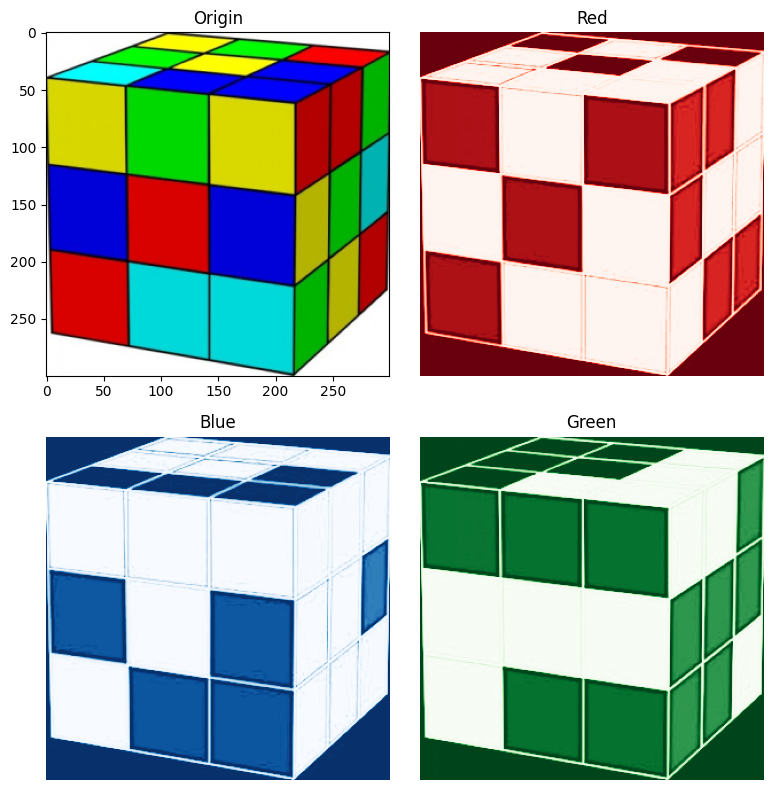

In [450]:
import random as rng
from scipy import ndimage as ndi

# crop image to have a square image
def crop_square(img, size, interpolation=cv2.INTER_AREA):
    h, w = img.shape[:2]
    min_size = np.amin([h,w])

    # Centralize and crop
    crop_img = img[int(h/2-min_size/2):int(h/2+min_size/2), int(w/2-min_size/2):int(w/2+min_size/2)]
    resized = cv2.resize(crop_img, (size, size), interpolation=interpolation)

    return resized

input_image = crop_square(cv2.imread('images/square9.png'), 300)

blue, green, red = cv2.split(input_image)

# high pass per il colore rosso -> evidenziazione dei bordi della immagine 
blur = cv2.GaussianBlur(red, (9,9), 0)
high_pass = cv2.subtract(red, blur)
high_pass = cv2.convertScaleAbs(high_pass, alpha = 3.0)
# combinazione high pass con l'immagine originale rossa
red = cv2.add(red, high_pass)

# high pass per il colore blu -> evidenziazione dei bordi della immagine 
blur = cv2.GaussianBlur(blue, (9,9), 0)
high_pass = cv2.subtract(blue, blur)
high_pass = cv2.convertScaleAbs(high_pass, alpha = 3.0)
# combinazione high pass con l'immagine originale blu
blue = cv2.add(blue, high_pass)

# high pass per il colore verde -> evidenziazione dei bordi della immagine 
blur = cv2.GaussianBlur(green, (9,9), 0)
high_pass = cv2.subtract(green, blur)
high_pass = cv2.convertScaleAbs(high_pass, alpha = 3.0)
# combinazione high pass con l'immagine originale verde
green = cv2.add(green, high_pass)

plt.figure(figsize=(8, 8))

# Prima immagine
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
plt.title('Origin')

# Seconda immagine
plt.subplot(2, 2, 2)
plt.imshow(red, cmap='Reds')
plt.title('Red')
plt.axis('off')

# Terza immagine
plt.subplot(2, 2, 3)
plt.imshow(blue, cmap='Blues')
plt.title('Blue')
plt.axis('off')

# Quarta immagine
plt.subplot(2, 2, 4)
plt.imshow(green, cmap='Greens')
plt.title('Green')
plt.axis('off')

plt.tight_layout()  # Aggiunge spaziatura tra le immagini per una migliore visualizzazione
plt.show()

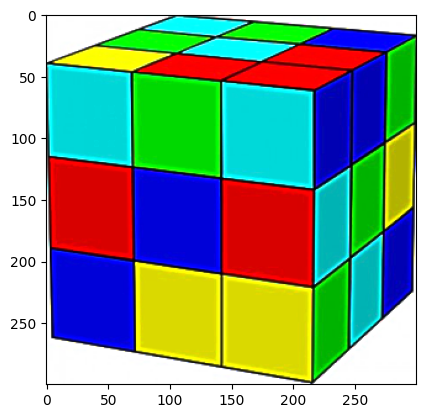

In [451]:
# Unione dei colori
from skimage.morphology import square
from skimage import filters

HP_gray_image = cv2.cvtColor(cv2.merge((blue, green, red)), cv2.COLOR_BGR2GRAY) # immagine High Pass in B/W
plt.imshow(cv2.merge((blue, green, red)))

In [452]:
#effettuo treshold dinamico per evidenziare i bordi del cubo
adaptive_gaussian = cv2.adaptiveThreshold(HP_gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 11) 

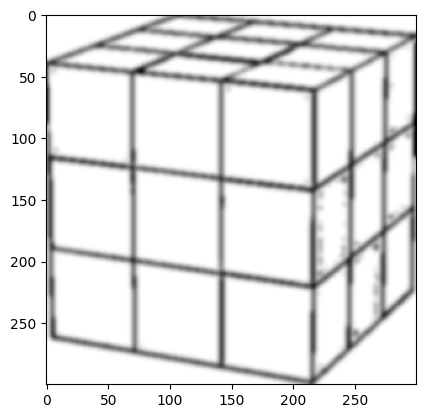

In [453]:
# altro step per smussare, dopo lo step precedente di resize
smooth = filters.gaussian(adaptive_gaussian, sigma=2)
plt.imshow(smooth,cmap="gray")

In [454]:
# effettuo canny, dato che la threshold non ha dei valori 0/255 ma DA 0 A 255, che non sono ottimali per gli step successivi
#smooth = np.array(smooth, dtype=np.float32)  # Ensure the data is in a float format
smooth = cv2.normalize(smooth, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

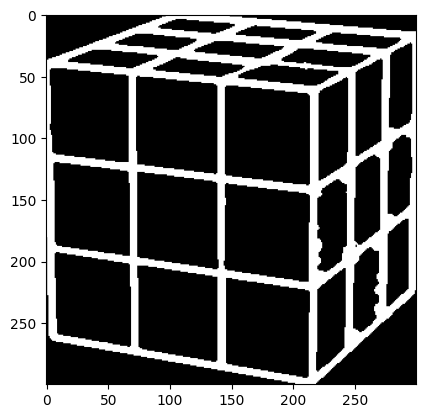

In [455]:
# rimozione di noise di fondo
_, smooth = cv2.threshold(smooth, 200, 255, cv2.THRESH_BINARY_INV)
plt.imshow(smooth,cmap="gray")

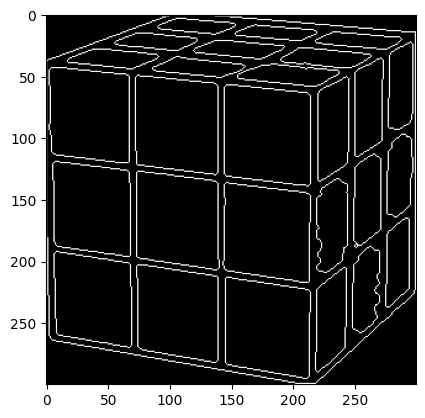

In [456]:
contours, hierarchy = cv2.findContours(smooth, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
borders = np.zeros_like(smooth)
edge_image = cv2.drawContours(borders, contours, -1, (255, 255, 255), 1)
plt.imshow(borders,cmap="gray")

In [457]:
# grazie al fatto che abbiamo solo 0 oppure solo 1, possiamo pocedere a dilatare, per rimpire buchi che possono esserci

#kernel = np.ones((3,3),np.uint8)
#dilatated = cv2.dilate(borders,kernel,iterations = 0)
#plt.imshow(dilatated,cmap="gray")

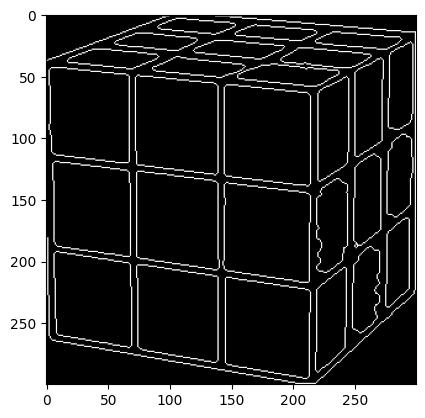

In [458]:
# diamo per scontato che ci possono essere delle linee orizzontali, quindi del rumore nel background
# per fare in modo di rimoverlo, creiamo uno cornice nera intorno alla immagine (se non c'è noise allora non è visibile)

thickness = 1

cv2.line(borders, (0,0), (0,300), (0,0,0), thickness)
cv2.line(borders, (0,300), (300,300), (0,0,0), thickness)
cv2.line(borders, (300,300), (300,0), (0,0,0), thickness)
cv2.line(borders, (300,0), (0,0), (0,0,0), thickness)

plt.imshow(borders,cmap="gray")

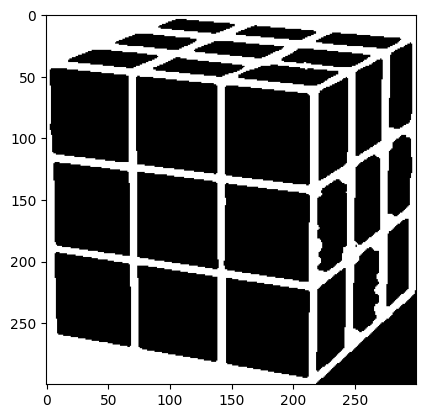

In [459]:
# facciamo un fill per rimuovere noise nel background, partendo dalla cornice nera creata precedentemente
# proprio grazia alla cornice, partendo da un solo punto, possiamo rimepire da tutto il bordo!

seed_point = (0, 0)
new_color = (255,255,255)

cv2.floodFill(borders, None, seed_point, new_color)

plt.imshow(borders,cmap="gray")

In [460]:
# aumento della dimensione della immagine

new_width, new_height = 500, 500

x_offset = (new_width - borders.shape[1]) // 2
y_offset = (new_height - borders.shape[0]) // 2

increased_dilatated = np.zeros((new_height, new_width), dtype=np.uint8)
increased_dilatated = 255 - increased_dilatated

increased_dilatated[y_offset:y_offset + borders.shape[0], x_offset:x_offset + borders.shape[1]] = borders

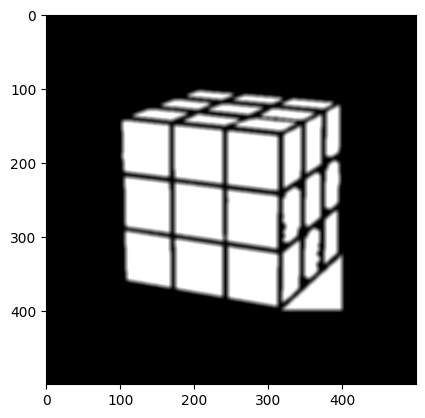

In [461]:
# effettuato mean kernel per cercare di smussare eventuale noise, e rimpire anche i buchi

mean_kernel = np.full((7, 7), 1/49)
mean = ndi.correlate(255 - increased_dilatated, mean_kernel)
plt.imshow(mean,cmap="gray")

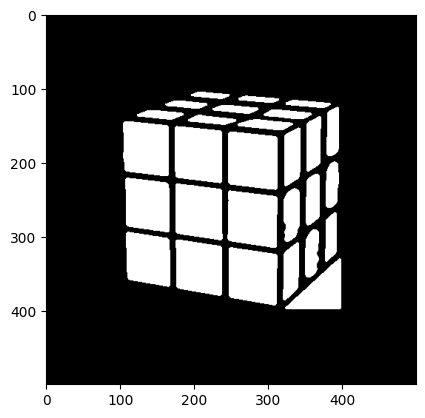

In [462]:
# effettuiamo threshold, portando a 255 tutto ciò che non è totalmente nero (si si vede che grazie allo smussamento molti buchi vengono riempiti)
ret,thresh = cv2.threshold(mean,150,255,cv2.THRESH_BINARY)
plt.imshow(thresh,cmap="gray")

area:2698.5
0.7539030974403468
area:4379.5
area:1277.5
area:4044.0
area:3730.5
area:953.5
area:808.5
0.7520760191555215
area:4480.0
area:1264.0
area:4212.0
area:3819.0
area:1091.0
area:876.0
0.7811741326180164
area:4705.0
area:1439.0
area:4381.0
area:4076.0
area:660.5
area:1194.0
area:485.0
area:495.0
area:523.5
area:935.5
area:442.0
area:375.5
area:371.0
area:294.0
area:287.0
perimeter of detected cube: 275.11269772052765


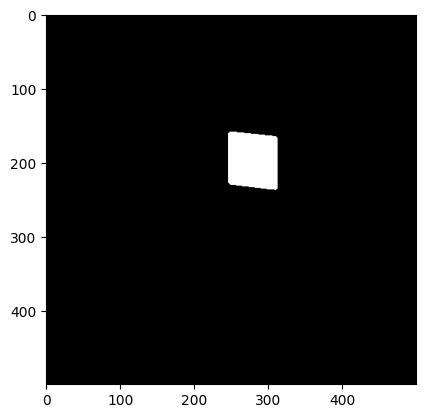

In [463]:
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

max_contour=contours[0]
max_area=cv2.contourArea(max_contour)

for i, c in enumerate(contours):
    area = cv2.contourArea(c)
    if(max_area<area and is_circle(c)):
        max_contour=c
        max_area=area
    print("area:"+str(area))

# Determine which area is larger and create a mask
single_thresh = np.zeros_like(thresh)
cv2.drawContours(single_thresh, [max_contour], -1, (255,255,255), -1)
perimeter = cv2.arcLength(max_contour, True)
print("perimeter of detected cube: "+str(perimeter))

# Apply the mask
plt.imshow(single_thresh,cmap="gray")

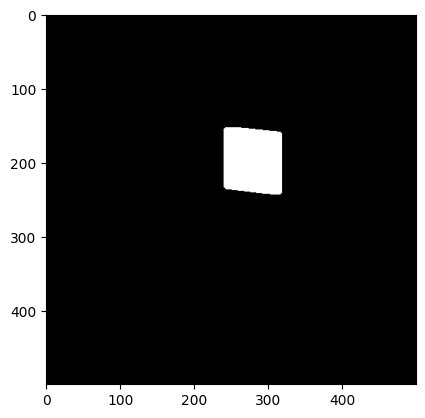

In [464]:
# espandiamo il colore bianco, per cercare di riempire i buchi, non solo all'interno ma anche sul bordo

kernel = np.ones((5,5),np.uint8)
erosion = cv2.dilate(single_thresh,kernel,iterations = 3)
plt.imshow(erosion,cmap="gray")

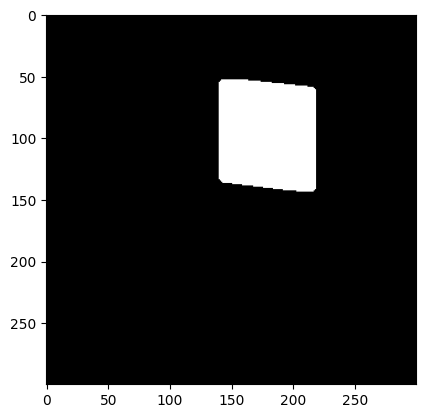

In [465]:
# Calculate the center of the original image
center_x, center_y = 500 // 2, 500 // 2
# Calculate half of the new dimensions
half_new_size = 300 // 2, 300 // 2

# Calculate the top-left corner of the new crop area
start_x = center_x - half_new_size[0]
start_y = center_y - half_new_size[1]
# Calculate the bottom-right corner of the new crop area
end_x = center_x + half_new_size[0]
end_y = center_y + half_new_size[1]

# Crop the image
cropped_erosion = erosion[start_y:end_y, start_x:end_x]
plt.imshow(cropped_erosion,cmap="gray")

(300, 300, 3)
(300, 300)


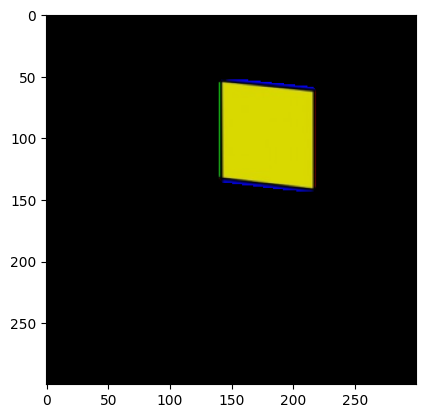

In [466]:
smaller_input_image = cv2.resize(input_image, (300, 300), interpolation = cv2.INTER_AREA)
x_offset = (new_width - smaller_input_image.shape[1]) // 2
y_offset = (new_height - smaller_input_image.shape[0]) // 2

print(smaller_input_image.shape)
print(cropped_erosion.shape)

result_image = cv2.bitwise_and(smaller_input_image, smaller_input_image, mask=cropped_erosion)
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))

Minimal Vertex Distance: 5.502253954410553


C:\Users\Ceron\AppData\Local\Temp\ipykernel_29040\157390378.py:6: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


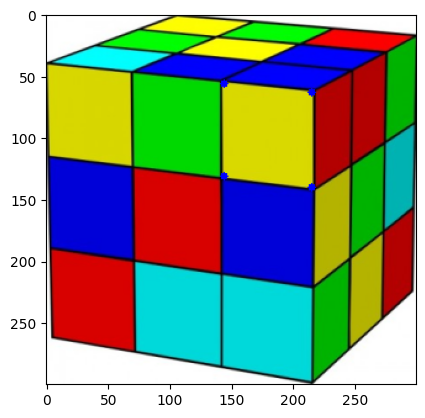

In [467]:
minimal_vertex_distance = perimeter/50
print("Minimal Vertex Distance: "+str(minimal_vertex_distance))
img = cv2.imread('blox.jpg')
gray = cv2.cvtColor(smaller_input_image,cv2.COLOR_BGR2GRAY)
corners = cv2.goodFeaturesToTrack(gray,maxCorners=0,qualityLevel=0.01,minDistance=minimal_vertex_distance,mask=cropped_erosion)
corners = np.int0(corners)
for i in corners:
    x,y = i.ravel()
    cv2.circle(smaller_input_image,(x,y),3,255,-1)
plt.imshow(cv2.cvtColor(smaller_input_image, cv2.COLOR_BGR2RGB))

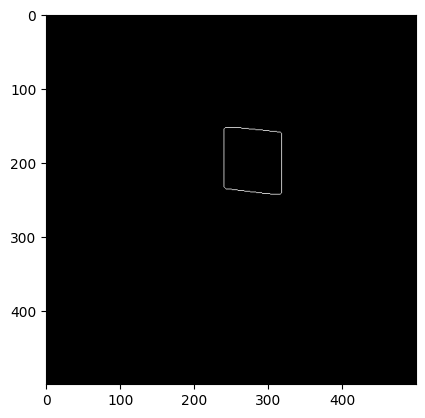

In [468]:
# trovato bordo del cubo di rubik
contours, hierarchy = cv2.findContours(erosion, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
edges = np.zeros_like(erosion)
edge_image = cv2.drawContours(edges, contours, -1, (255, 255, 255), 1)
plt.imshow(edges,cmap="gray")

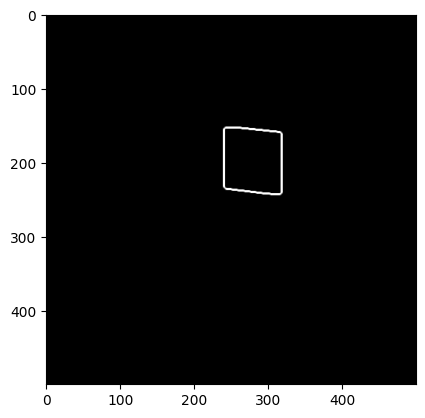

In [469]:
# dato che il borso è estremamente pieno di rumore, effettuo smussamento per cercare di renderlo più una liena, anzichè un continuo alto/basso
mean_kernel = np.full((3, 3), 1/9)
edges = ndi.correlate(edges, mean_kernel)
plt.imshow(edges,cmap="gray")

Minimal assumed edge lenght: 25.218663957715037
Maximal assumed line gap: 11.463029071688652


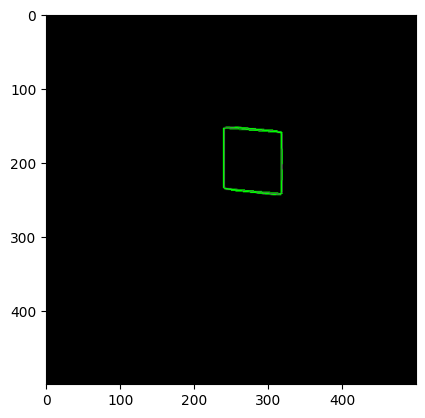

In [470]:
# dato che le linee del bordo trovate finora sono anche piene di noise, nonostante lo smussamento, uso una funzione che data una forma, si ricava delle linee DRITTE
minimal_edge_length = (perimeter/6)*0.55 # deve dipendere dalla vicinanza del cubo di rubik dalla immagine!
print("Minimal assumed edge lenght: "+str(minimal_edge_length))
print("Maximal assumed line gap: "+str((perimeter/6)*0.25))
lines = cv2.HoughLinesP(edges, 3, np.pi/200, threshold=25, minLineLength=minimal_edge_length, maxLineGap=(perimeter/6)*0.25)

# Disegna le linee sull'immagine originale per visualizzazione
image_with_lines = image_with_lines = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 1)
plt.imshow(image_with_lines,cmap="gray")

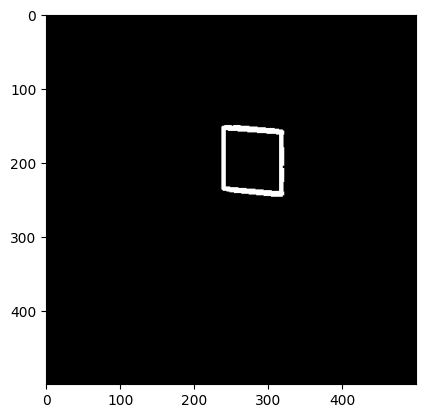

In [471]:
# 

void = np.zeros_like(edges)
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(void, (x1, y1), (x2, y2), 255, 1)
void = cv2.dilate(void,kernel,iterations = 1)
plt.imshow(void,cmap="gray")

In [472]:
def extract_shape(border):
    contours = []
    kernel = np.ones((5,5),np.uint8)
    seed_point = (0, 0)
    new_color = (255,255,255)

    loops=0

    while(not len(contours)==1):
        loops+=1
        border = cv2.dilate(border,kernel,iterations = 1)

        void2 = border.copy()
        cv2.floodFill(void2, None, seed_point, new_color)

        contours, _ = cv2.findContours(cv2.bitwise_not(void2), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours, loops

1


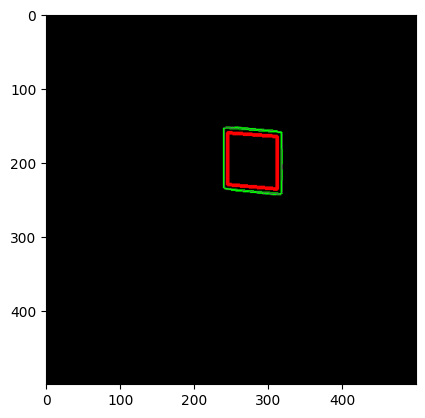

In [473]:
contours, loops = extract_shape(void)

print(loops)
epsilon = 0.02 * cv2.arcLength(contours[0], True)
approx_polygon = cv2.approxPolyDP(contours[0], epsilon, True)

if(loops>2):
    approx_polygon = scale_polygon(approx_polygon, 1+(loops-1)*0.025)

tmp = cv2.cvtColor(np.zeros_like(void),cv2.COLOR_GRAY2RGB)
cv2.drawContours(image_with_lines, [approx_polygon], -1, (0,0,255), thickness = 3)
plt.imshow(cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB))

In [474]:
decreased_polygon = approx_polygon - 100
decreased_polygon = np.round(decreased_polygon).astype(np.int32)

sorted_vertices = sorted(decreased_polygon, key=lambda point: point[0][1])
highest_vertex = sorted_vertices[0][0]
lowest_vertex = sorted_vertices[-1][0]

tmp = cv2.resize(input_image, (300, 300), interpolation = cv2.INTER_AREA)
cv2.drawContours(tmp, [decreased_polygon], -1, (0, 0, 255), thickness = 3)

upper_right=lower_right=upper_left=lower_left=0
if(sorted_vertices[1][0][0] > sorted_vertices[2][0][0]):
    upper_right = sorted_vertices[1][0]
    upper_left = sorted_vertices[2][0]
else:
    upper_right = sorted_vertices[2][0]
    upper_left = sorted_vertices[1][0]
if(sorted_vertices[3][0][0] > sorted_vertices[4][0][0]):
    lower_right = sorted_vertices[3][0]
    lower_left = sorted_vertices[4][0]
else:
    lower_right = sorted_vertices[4][0]
    lower_left = sorted_vertices[3][0]

perspective = (upper_left[1]-highest_vertex[1])+(upper_right[1]-highest_vertex[1])
shift = (upper_right[1]-upper_left[1])


center = (lowest_vertex[0]+int(shift*0.2), sorted_vertices[0][0][1] + int(np.exp(perspective/87)*37))
cv2.circle(tmp, center, 5, (0,0,255), thickness=cv2.FILLED)


plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

IndexError: list index out of range

Point error correction: 7.860362792015076


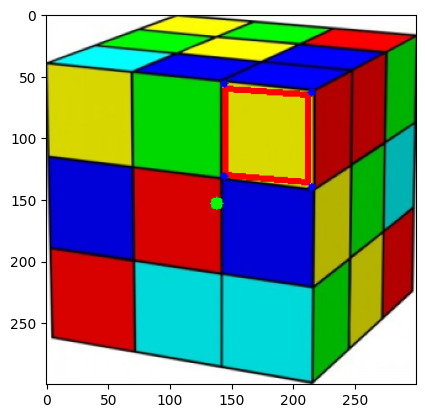

In [475]:
# unione del "good features to track" con il metodo base
print("Point error correction: "+str(perimeter/35))
# correzzione del punto centrale (prima rosso, ora giallo)
min_distance=300
min_coordinates=(0,0)
for i in corners:
    x,y = i.ravel()
    distance = np.abs(x-center[0])+np.abs(y-center[1])
    if(distance < min_distance and distance < perimeter/35):
        min_distance = distance
        min_coordinates = (x,y)
    cv2.circle(tmp,(x,y),3,255,-1)
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

old_center = center
if(min_distance!=300):
    center = min_coordinates

cv2.circle(tmp, center, 5, (0,255,0), thickness=cv2.FILLED)
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

In [476]:
TOP = 0
SX1 = 1
SX2 = 2
BOTTOM = 3
DX2 = 4
DX1 = 5

# correzzione dei 6 angoli esterni SE ENTRO RANGE ACCETTABILE
min_distances=np.array([300,300,300,300,300,300])
min_coordinates=np.array([(0,0),(0,0),(0,0),(0,0),(0,0),(0,0)])
original_coordinates=np.array([sorted_vertices[0][0], upper_left, lower_left, lowest_vertex, lower_right, upper_right])
for i in corners:
    x,y = i.ravel()
    for i in range(6):
        distance = np.abs(x-original_coordinates[i][0])+np.abs(y-original_coordinates[i][1])
        if(distance < min_distances[i] and distance < perimeter/35):
            min_distances[i] = distance
            min_coordinates[i] = np.array([x,y])

for i in range(6):
    if(min_distances[i]!=300):
        original_coordinates[i]=min_coordinates[i]

tmp = cv2.resize(input_image, (300, 300), interpolation = cv2.INTER_AREA)

cv2.drawContours(tmp, [decreased_polygon], -1, (0, 0, 255), thickness = 3)
cv2.circle(tmp, old_center, 5, (0,0,255), thickness=cv2.FILLED)

for i in range(6):
    cv2.line(tmp, original_coordinates[i], original_coordinates[(i+1)%6], (0, 255, 0), thickness = 3)

cv2.circle(tmp, center, 5, (0,255,0), thickness=cv2.FILLED)
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6,) + inhomogeneous part.

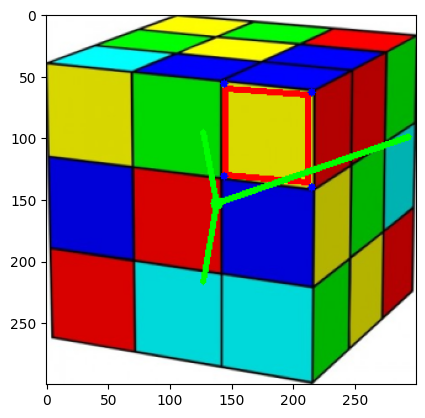

In [477]:
cv2.line(tmp, original_coordinates[BOTTOM], center, (0, 255, 0), thickness = 3)
cv2.line(tmp, original_coordinates[SX1], center, (0, 255, 0), thickness = 3)
cv2.line(tmp, original_coordinates[DX1], center, (0, 255, 0), thickness = 3)

plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

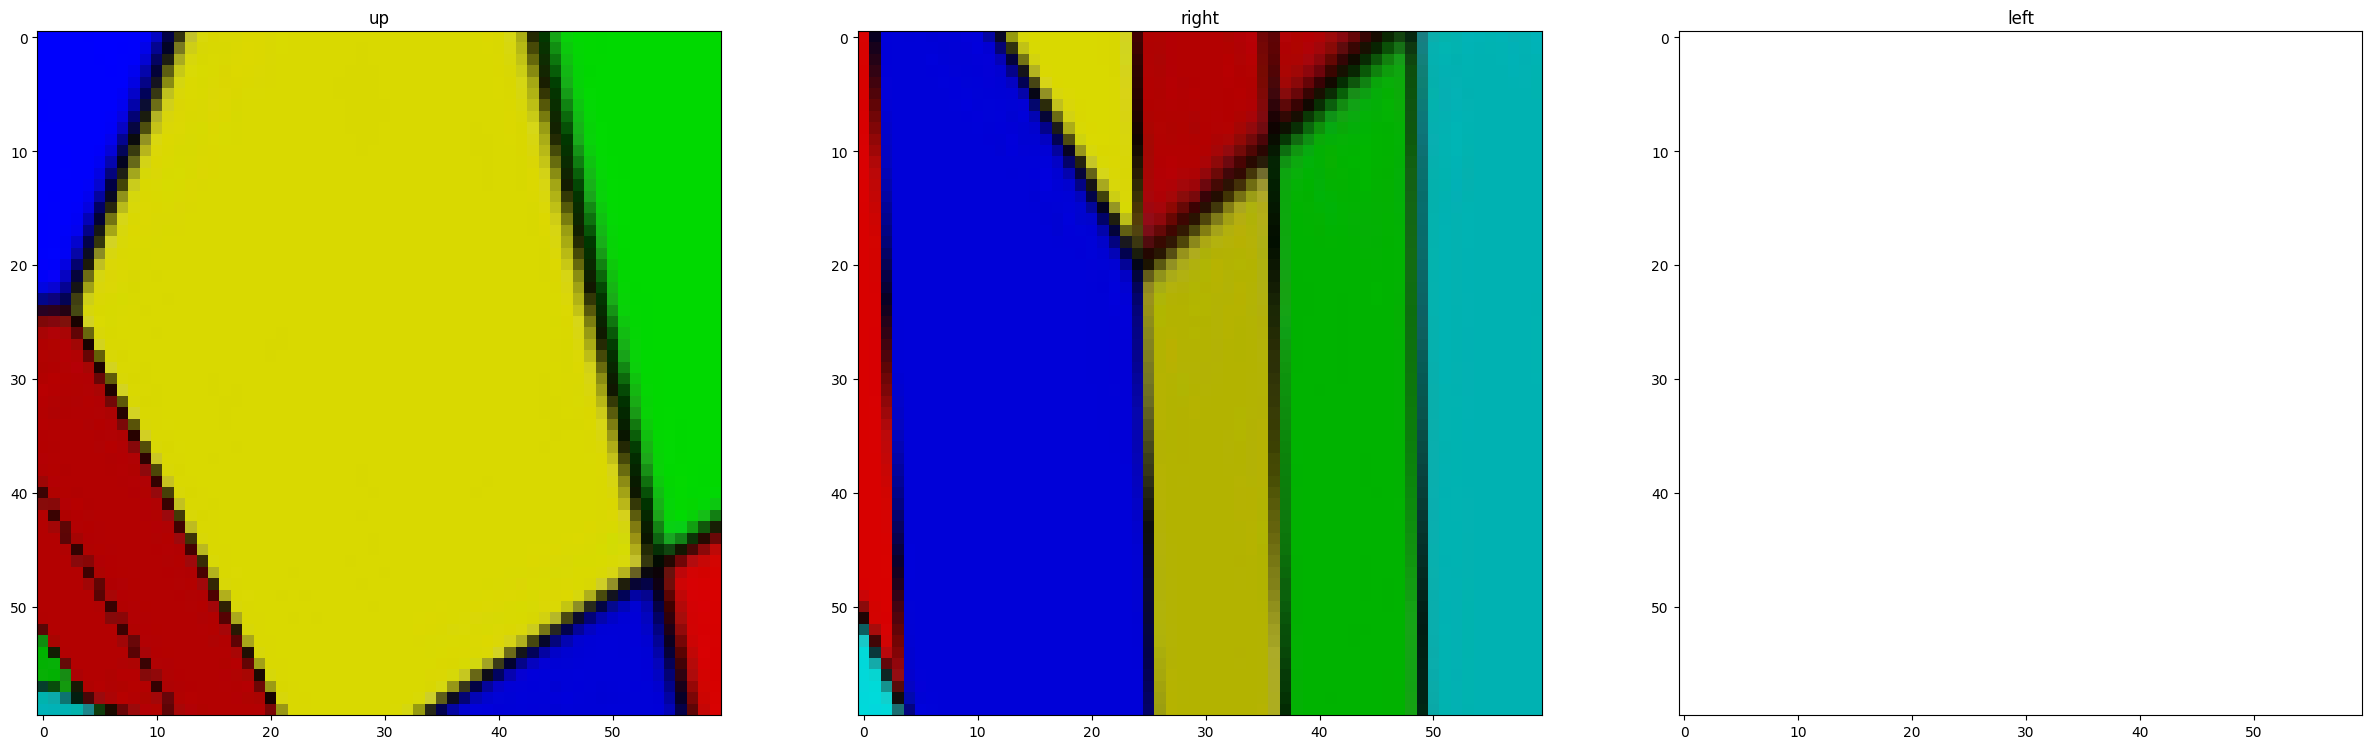

In [478]:
dst_square_size = 60
tmp = cv2.resize(input_image, (300, 300), interpolation = cv2.INTER_AREA)
dst_coordinates = np.array([[0, 0], [dst_square_size - 1, 0], [dst_square_size - 1, dst_square_size - 1], [0, dst_square_size - 1]], dtype=np.float32)

coordinates = np.array([original_coordinates[TOP], original_coordinates[SX1], center, original_coordinates[DX1]], dtype=np.float32)
src_coordinates = np.array(coordinates, dtype=np.float32)
perspective_matrix = cv2.getPerspectiveTransform(src_coordinates, dst_coordinates)
result_image1 = cv2.warpPerspective(tmp, perspective_matrix, (dst_square_size, dst_square_size))


coordinates = np.array([ center, original_coordinates[DX1], original_coordinates[DX2], original_coordinates[BOTTOM]], dtype=np.float32)
src_coordinates = np.array(coordinates, dtype=np.float32)
perspective_matrix = cv2.getPerspectiveTransform(src_coordinates, dst_coordinates)
result_image2 = cv2.warpPerspective(tmp, perspective_matrix, (dst_square_size, dst_square_size))

coordinates = np.array([ original_coordinates[BOTTOM], original_coordinates[SX2], original_coordinates[SX1], center], dtype=np.float32)
src_coordinates = np.array(coordinates, dtype=np.float32)
perspective_matrix = cv2.getPerspectiveTransform(src_coordinates, dst_coordinates)
result_image3 = cv2.warpPerspective(tmp, perspective_matrix, (dst_square_size, dst_square_size))

imshow_all(cv2.cvtColor(result_image1, cv2.COLOR_BGR2RGB),cv2.cvtColor(result_image2, cv2.COLOR_BGR2RGB),cv2.cvtColor(result_image3, cv2.COLOR_BGR2RGB),titles=["up","right","left"])

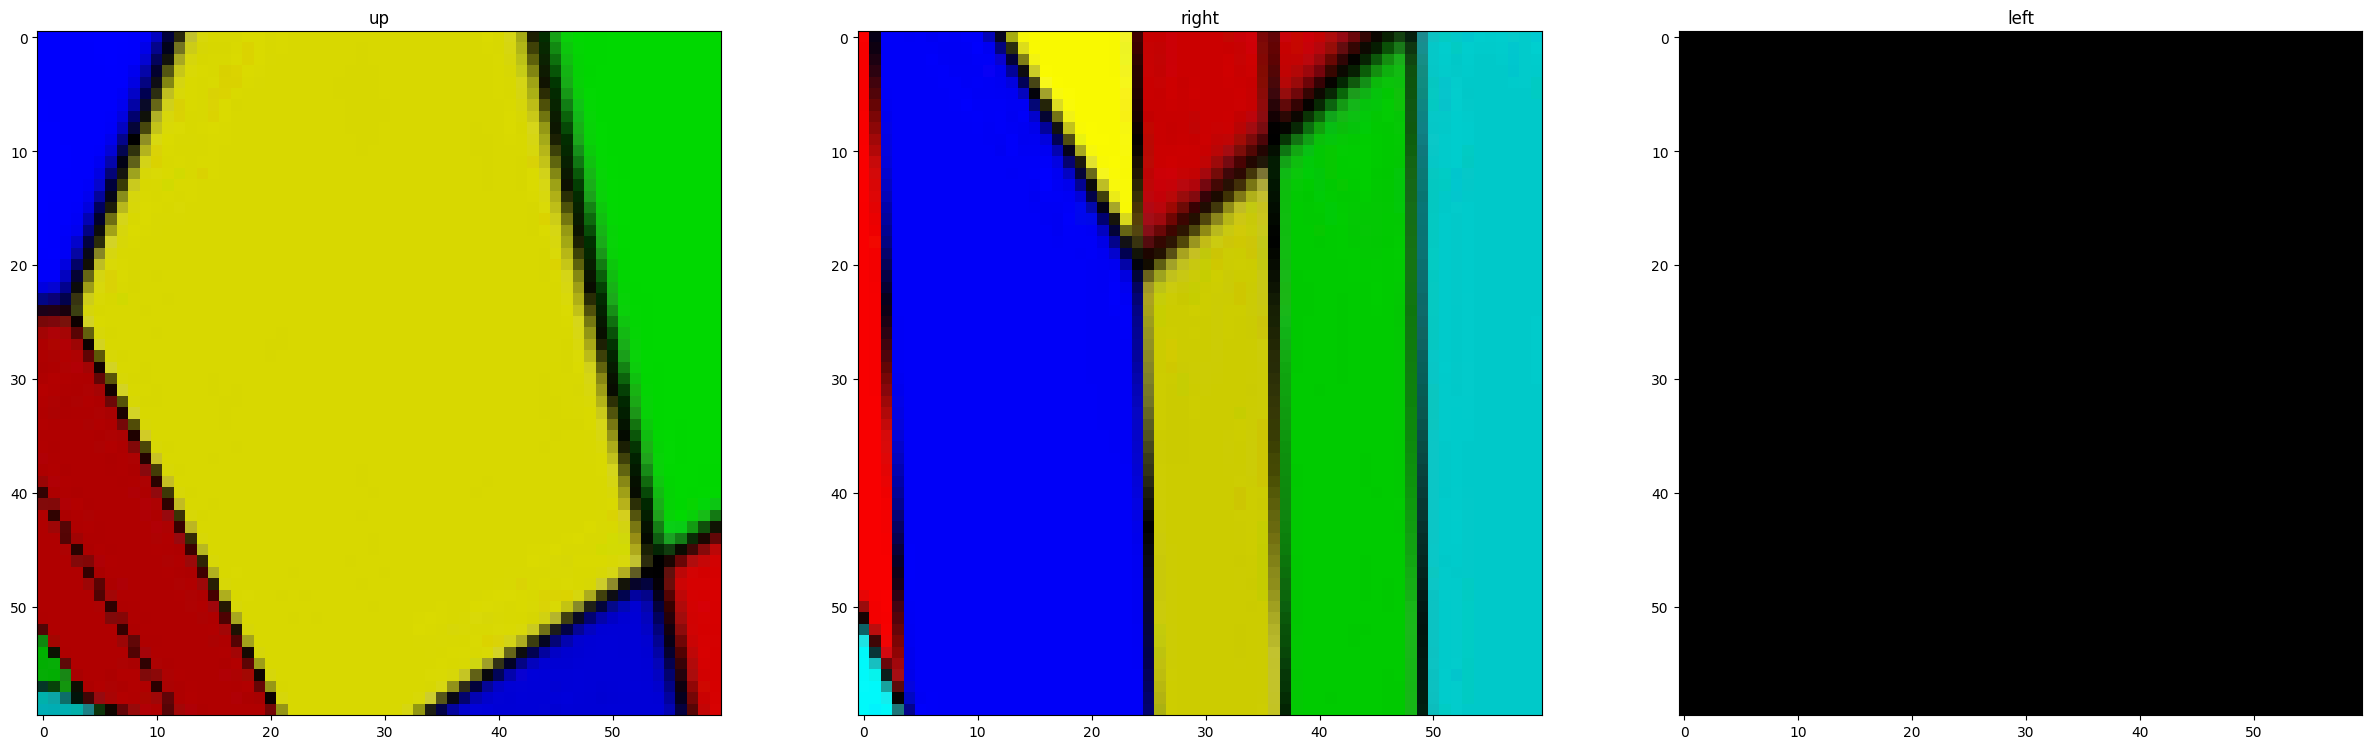

In [479]:
hsv1 = cv2.cvtColor(result_image1, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv1)
s = cv2.normalize(s, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
v = cv2.normalize(v, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
result_image1 = cv2.merge([h, s, v])
result_image1 = cv2.cvtColor(result_image1, cv2.COLOR_HSV2BGR)

hsv2 = cv2.cvtColor(result_image2, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv2)
s = cv2.normalize(s, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
v = cv2.normalize(v, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
result_image2 = cv2.merge([h, s, v])
result_image2 = cv2.cvtColor(result_image2, cv2.COLOR_HSV2BGR)

hsv3 = cv2.cvtColor(result_image3, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv3)
s = cv2.normalize(s, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
v = cv2.normalize(v, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
result_image3 = cv2.merge([h, s, v])
result_image3 = cv2.cvtColor(result_image3, cv2.COLOR_HSV2BGR)

imshow_all(cv2.cvtColor(result_image1, cv2.COLOR_BGR2RGB),cv2.cvtColor(result_image2, cv2.COLOR_BGR2RGB),cv2.cvtColor(result_image3, cv2.COLOR_BGR2RGB),titles=["up","right","left"])

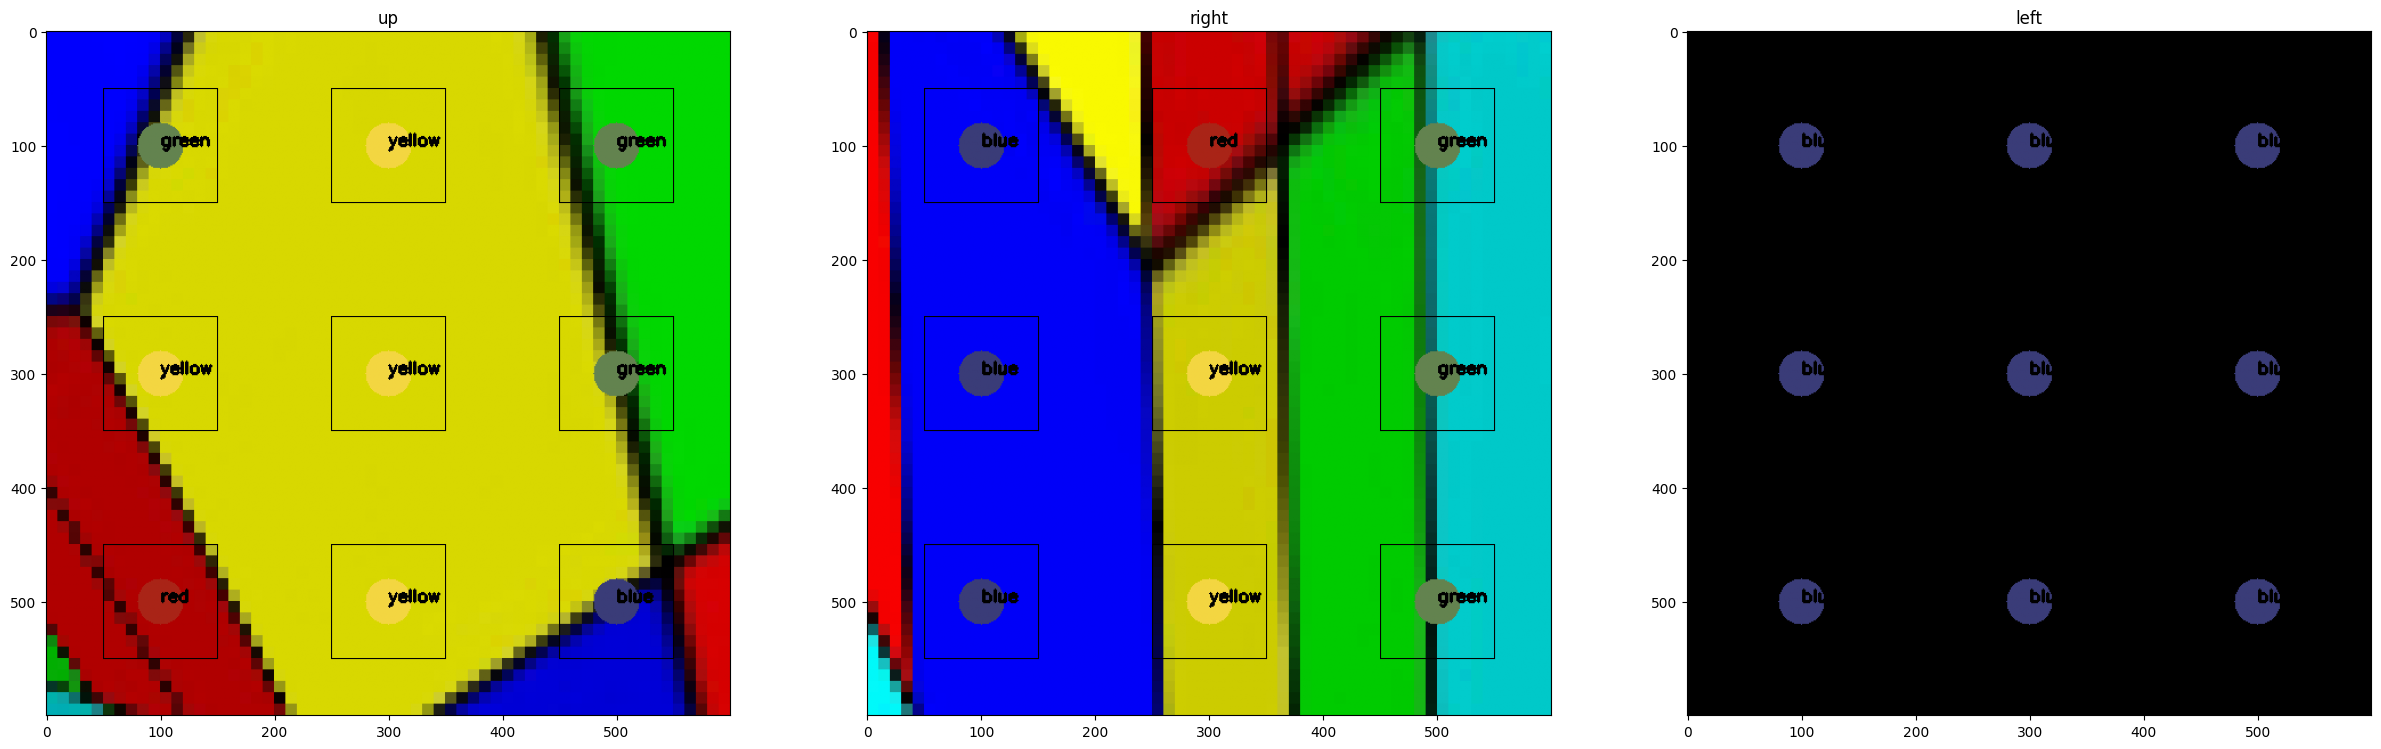

In [480]:

def find_closest_color_vector(color_at_center):
    color_palette = {
        'red': (23, 36, 169),
        'green': (79, 131, 99),
        'blue': (120, 60, 58),
        'white': (180, 180, 180),
        'yellow': (65, 214, 244),
        'orange': (8, 106, 237)
    }
    diff=255*3
    color=("",(0,0,0))
    for i in color_palette.keys():
        tmp_diff = sum((c1 - c2) ** 2 for c1, c2 in zip(color_at_center, color_palette[i])) ** 0.5
        if tmp_diff < diff:
            diff = tmp_diff
            color = (i,color_palette[i])
    return color

tmp1 = cv2.resize(result_image1, (600, 600), interpolation = cv2.INTER_AREA)
tmp2 = cv2.resize(result_image2, (600, 600), interpolation = cv2.INTER_AREA)
tmp3 = cv2.resize(result_image3, (600, 600), interpolation = cv2.INTER_AREA)

for i in np.arange(10,60,20):
    for j in np.arange(10,60,20):
        average_color = np.mean(result_image1[j-5:j+5, i-5:i+5], axis=(0,1))
        closest_color = find_closest_color_vector(average_color)
        cv2.rectangle(tmp1, ((j-5)*10, (i-5)*10), ((j+5)*10, (i+5)*10), (0, 0, 0), 1)
        cv2.circle(tmp1, (i*10, j*10), 20, closest_color[1], thickness=cv2.FILLED)
        cv2.putText(tmp1, closest_color[0], (i*10, j*10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

for i in np.arange(10,60,20):
    for j in np.arange(10,60,20):
        average_color = np.mean(result_image2[j-5:j+5, i-5:i+5], axis=(0,1))
        closest_color = find_closest_color_vector(average_color)
        cv2.rectangle(tmp2, ((j-5)*10, (i-5)*10), ((j+5)*10, (i+5)*10), (0, 0, 0), 1)
        cv2.circle(tmp2, (i*10, j*10), 20, closest_color[1], thickness=cv2.FILLED)
        cv2.putText(tmp2, closest_color[0], (i*10, j*10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

for i in np.arange(10,60,20):
    for j in np.arange(10,60,20):
        average_color = np.mean(result_image3[j-5:j+5, i-5:i+5], axis=(0,1))
        closest_color = find_closest_color_vector(average_color)
        cv2.rectangle(tmp3, ((j-5)*10, (i-5)*10), ((j+5)*10, (i+5)*10), (0, 0, 0), 1)
        cv2.circle(tmp3, (i*10, j*10), 20, closest_color[1], thickness=cv2.FILLED)
        cv2.putText(tmp3, closest_color[0], (i*10, j*10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

imshow_all(cv2.cvtColor(tmp1, cv2.COLOR_BGR2RGB),cv2.cvtColor(tmp2, cv2.COLOR_BGR2RGB),cv2.cvtColor(tmp3, cv2.COLOR_BGR2RGB),titles=["up","right","left"])